# Package loading

In [1]:
import numpy as np
import pandas as pd
import os
import shapely
from shapely.geometry.point import Point
from shapely.geometry import Polygon, LineString
import dxfgrabber as dxfgb
import matplotlib.pyplot as plt
import math

# Package documentation

http://dxfgrabber.readthedocs.io/en/latest/  
https://shapely.readthedocs.io/en/latest/

# DXF loading

In [2]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample', 'DXF')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]
dxflist

['/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/a5377710_lr.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/b2069320_lr.dxf',
 '/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/c5602250_lr.dxf']

In [50]:
dxf = dxfgb.readfile(dxflist[0])
print("DXF version: {}".format(dxf.dxfversion))


DXF version: AC1015


In [4]:
header_var_count = len(dxf.header) # dict of dxf header vars
header_var_count

36

In [5]:
layer_count = len(dxf.layers) # collection of layer definitions
layer_count

14

In [6]:
block_definition_count = len(dxf.blocks) #  dict like collection of block definitions
block_definition_count

2

In [7]:
entity_count = len(dxf.entities) # list like collection of entities
entity_count

51

In [18]:
a = [1,2,3,1,50, 50,50]
counts = np.bincount(a)
np.argmax(counts)

50

In [59]:
for element in [element for element in dxf.modelspace()]: #   if element.dxftype == 'MTEXT'
#for element in [element for element in dxf.modelspace() if element.dxftype == 'MTEXT']: #
#for element in [element for element in dxf.modelspace() if element.dxftype == 'LINE' and element.color == 2]:
    #print(np.round(x.start,3))
    #print(element)
    print(element.color)
    try:
        print(element.points)
        print(element.is_closed)
    except:
        pass
    try:
        print(element.plain_text(split=False))
        print(element.lines())
        print(element.insert)
    except:
        pass
    print(element.linetype)
    #
    #print(element.insert)
    #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
    #print(np.round(element.control_points, 3)[:,0:2])
    print()

5
ECHELLE 1
['ECHELLE 1']
(201.9956936643, -189.2488005983, 0.0)
CONTINUOUS

5
 90.00~UP
['{\\Ftxt.shx;\\W1.875000;\\H3.500000; }90.00\\Fgdt;{\\Fgdt;~}\\Ftxt;UP']
(259.8680881768, 129.3074993711, 0.0)
CONTINUOUS

5
 90.00~UP
['{\\Ftxt.shx;\\W1.875000;\\H3.500000; }90.00\\Fgdt;{\\Fgdt;~}\\Ftxt;UP']
(208.6830968517, 425.5810665659, 0.0)
CONTINUOUS

5
 90.00~UP
['{\\Ftxt.shx;\\W1.875000;\\H3.500000; }90.00\\Fgdt;{\\Fgdt;~}\\Ftxt;UP']
(99.9083579459, 286.679428607, 0.0)
CONTINUOUS

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

7
CONTINUOUS

7
CONTINUOUS

7
CONTINUOUS

7
CONTINUOUS

5
[(214.078927002, 425.2893823242), (208.6830908203, 422.0810888672), (214.078927002, 422.0810888672)]
False
CONTINUOUS

7
CONTINUOUS

7
CONTINUOUS

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

2
CENTER

7
CONTINUOUS

5
[(105.3041885376, 286.3877636719), (99.9083587646, 283.1794189453), (105.3041885376, 283.1794189453)]
False
CONTINUOUS

7
CONTINUOUS

2
CENTER

2
CENTER

2


# DXF reading module

In [107]:
class DxfParser():
    def __init__(self, edge_color=[3, 7], #List of possible colors for cuted edges
                 etching_color=2,
                 min_edge_length=.5, #Maximum length for ARCS and ELLIPSE
                 roundigexp=4, #Number of digits to keep
                 max_distance_correction=.75, #Maximum distance to close open loops
                ):
        """Class parameters definition"""
        self.min_edge_length = min_edge_length
        self.etching_color = etching_color
        self.edge_color = edge_color
        self.roundigexp = roundigexp
        self.details = {}
        self.color = 0 #Will be updated each time we load a new dxf file
    
    def load_dxf(self, dxfpath):
        """Loads the DXF file"""
        self.dxf = dxfgb.readfile(dxfpath)
        #Most common color calculation
        colors = [element.color for element in self.dxf.modelspace() if element.linetype == 'CONTINUOUS']
        self.color = np.argmax(np.bincount(colors))
        print(self.color)

    
    def _bend_placement(self):
        """Populates information such as nuber of bends, direction"""
        leader = []
        axis = []
        #List of axis creation
        toparse = [element for element in self.dxf.modelspace() if element.linetype == 'CENTER' and element.dxftype == 'LINE' ]
        for lines in toparse:
            segment = np.round((lines.start, lines.end), decimals=self.roundigexp)[:,0:2]
            axis.append(segment)

        centeraxis = [((x[0,0]+x[1,0])/2, (x[0,1]+x[1,1])/2) for x in axis]
        #print(centeraxis)
        
        #bend list creation
        toparse = [element for element in self.dxf.modelspace() if element.layer == 'NOTES' and element.dxftype == 'MTEXT']
        bend_angle = []
        bend_direction = []
        bend_index = []
        for element in toparse:
            text = element.plain_text(split=False)
            print(text)
            if text.endswith('UP') or text.endswith('DOWN'):
                temp = text.split('~')
                bend_angle.append(float(temp[0].strip()))
                bend_direction.append(temp[1])
                x, y, _ = element.insert
                if temp[1] == 'UP':
                    coordtext = (x-6.25,y-4.5)
                else:
                    coordtext = (x-6.25,y+0.75)
                print(coordtext)
                distances = np.array([LineString((coordtext,coord)).length for coord in centeraxis])
                print(distances.min())
                bend_index.append(np.argmin(distances))
        
        self.details['bend_angle'] = bend_angle
        self.details['bend_direction'] = bend_direction
        self.details['bend_line'] = [axis[k] for k in bend_index]                
            
    
    def _pattern_details(self, color):
        """Constructs the pattern with shapely"""
        patterns = []
        closedpatterns = []
        openpatterns = [] #Used to track all the segment in the DXF
        toparse = [element for element in self.dxf.modelspace() if element.color == self.color and element.linetype == 'CONTINUOUS']
        print(len(toparse))
        validentities = ['LINE', 'ARC', 'ELLIPSE', 'CIRCLE', 'SPLINE', 'LWPOLYLINE']
        for element in [x for x in toparse if x.dxftype in validentities]:
            #print(element)
            if element.dxftype == 'LINE':
                coordsectlist = np.round(np.array((element.start, element.end)), decimals=self.roundigexp)
            elif element.dxftype == 'MTEXT':
                print(element.raw_text)
            elif element.dxftype == 'ARC':
                segment = self._arccoord(element.center, element.radius, element.start_angle, element.end_angle)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
            elif element.dxftype == 'ELLIPSE':
                segment = self._ellipsecoord(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
                #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
            elif element.dxftype == 'CIRCLE':
                center = Point([round(x, self.roundigexp) for x in element.center])
                circle = center.buffer(element.radius)
                coordsectlist = np.round(circle.exterior.coords, self.roundigexp)
            elif element.dxftype == 'SPLINE':
                coordsectlist = np.round(element.control_points, self.roundigexp)[:,0:2]
                #print(element.control_points)
            elif element.dxftype == 'LWPOLYLINE':
                coordsectlist = np.round(element.points, self.roundigexp)
            
            #List of segment construction
            if element.dxftype not in ['CIRCLE', ]:
                patterns.append(coordsectlist)
            else:
                closedpatterns.append(coordsectlist)
        
        #Construcion of the different patterns
        currentsegment = np.array(patterns[0])
        del patterns[0]
        looping = True
        
        while looping:
            initloop=False
            
            for index, segment in enumerate(patterns):
                modifiedloop = False
                
                start = tuple(np.array(segment[0]).tolist())
                end = tuple(np.array(segment[-1]).tolist())
                startsegment = tuple(np.round(currentsegment[0], self.roundigexp).tolist())
                endsegment = tuple(np.round(currentsegment[-1], self.roundigexp).tolist())
                
                #print(currentsegment.shape)
                
                #Attachment 1?
                if endsegment == start:
                    currentsegment = np.concatenate((currentsegment, segment[::]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 2?
                elif endsegment == end:
                    currentsegment = np.concatenate((currentsegment, segment[::-1]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 3?
                elif startsegment == start:
                    currentsegment = np.concatenate((segment[::-1], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 4?
                elif startsegment == end:
                    currentsegment = np.concatenate((segment[::], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                    

            #Exhausted all the options?
            if tuple(currentsegment[0]) == tuple(currentsegment[-1]): #The loop is closed ?
                closedpatterns.append(currentsegment)
                print('closed loop')
                initloop=True
                modifiedloop = True
                
            if not modifiedloop: # The loop is not closed and we exhausted all the options
                openpatterns.append(currentsegment)
                initloop=True
                print('open loop')
                print(startsegment, endsegment)
            
            if len(patterns) == 0: #All the segments have been parsed
                looping = False
            
            if initloop and len(patterns) != 0: #We finished a segment and need to initiate a new one
                #print("New segment")
                currentsegment = np.array(patterns[0]) 
                del patterns[0]
                initloop = False
                        

        return (closedpatterns, openpatterns)
            
    
    def _surface(self):
        """Misc Surface calculation"""
        areas = np.array([Polygon(poly).area for poly in self.details['closed_patterns']])
        lengths = np.array([Polygon(poly).length for poly in self.details['closed_patterns']])
        biggestarea = np.argmax(areas)
        
        self.details['cut_length'] = lengths.sum()
        self.details['total_area'] = 2 * areas[biggestarea] - areas.sum()
        mainpattern = Polygon(self.details['closed_patterns'][biggestarea])
        self.details['minimum_rectangle_coords'] = mainpattern.minimum_rotated_rectangle.exterior.coords[:]
        self.details['minimum_rectangle_area'] = Polygon(self.details['minimum_rectangle_coords']).area
        
        self.details['num_closed_patterns'] = len(self.details['closed_patterns'])
        self.details['num_open_patterns'] = len(self.details['open_patterns'])
        
        self.details['convex_hull_coords'] = mainpattern.convex_hull.exterior.coords[:]
        self.details['convex_hull_area'] = Polygon(self.details['convex_hull_coords']).area

    
    def _arccoord(self, center, radius, start_angle, end_angle):
        """Sub-feature to calculate arc coordiantes"""
        xc, yc = center
        if start_angle > end_angle:
            start_angle -= 360
        cord = self.min_edge_length if radius > self.min_edge_length else radius #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_details = math.floor(np.radians(end_angle - start_angle) / angle_eq)
        steps_number = np.array((2, abs(steps_details))).max()
        toreturn = np.array([])
        for angle in np.linspace(np.radians(start_angle), np.radians(end_angle), steps_number):
            xa = xc + radius * np.cos(angle)
            ya = yc + radius * np.sin(angle)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        #print(center, radius, start_angle, end_angle, steps_number)
        return toreturn.reshape(-1,2)
    
    def _ellipsecoord(self, center, major_axis, ratio, start_angle, end_angle):
        """Sub-feature to calculate ellipse coordiantes"""
        xc, yc, _ = center
        xe, ye, _ = major_axis
        rmax = np.sqrt(xe**2 + ye**2)
        rmin = rmax * ratio
        radius = (rmin+rmax)/2

        if xe == 0 and ye > 0:
            angle_ellipse = np.pi/2
        elif xe == 0 and ye < 0:
            angle_ellipse = -np.pi/2
        elif ye == 0 and xe > 0:
            angle_ellipse = 0
        elif ye == 0 and xe < 0:
            angle_ellipse = np.pi
        elif xe < 0 and ye < 0:
            angle_ellipse = np.arctan(ye / xe) + np.pi
        elif xe < 0 and ye > 0:
            angle_ellipse = np.pi - np.arctan(ye / xe)
        else:
            angle_ellipse = np.arctan(ye / xe)


        if start_angle > end_angle:
            start_angle -= np.pi

        cord = radius if radius < self.min_edge_length else self.min_edge_length #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_number = math.floor((end_angle - start_angle) / angle_eq)
        toreturn = np.array([])
        for angle in np.linspace(start_angle, end_angle, steps_number):
            intx = rmax * np.cos(angle)
            inty = rmin * np.sin(angle)
            xa = xc + intx * np.cos(angle_ellipse) - inty * np.sin(angle_ellipse)
            ya = yc + intx * np.sin(angle_ellipse) + inty * np.cos(angle_ellipse)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        return toreturn.reshape(-1,2)

    
    def parse(self, dxfpath):
        """Method to call to parse a DXF file, will return a dict with all the needed information"""
        self.load_dxf(dxfpath)
        #Cutting patter
        self.details['closed_patterns'], self.details['open_patterns']= self._pattern_details(self.edge_color)

        #Hetching pattern
        #TO DO
        
        #surface calculations
        self._surface()
        self._bend_placement()
        
        
        
        return self.details
    
    def set_params(self, **kwargs):
        """Used to set all the params"""
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def get_params(self):
        """Method to get all the parameters of the DXF parser"""
        return {key:value for key, value in vars(self).items()}

In [121]:
dxfparser = DxfParser(min_edge_length=1)
print(dxflist[0])
details = dxfparser.parse(dxflist[0])
details.keys()
#details['closed_patterns']
#details['total_surface']

/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/DXF/a5377710_lr.dxf
7
84
closed loop
closed loop
closed loop
closed loop
closed loop
closed loop
ECHELLE 1
 90.00~UP
(253.61808817679997, 124.8074993711)
0.279519353472
 90.00~UP
(202.4330968517, 421.0810665659)
0.279526266749
 90.00~UP
(93.6583579459, 282.179428607)
5.25403179416


dict_keys(['closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'num_closed_patterns', 'num_open_patterns', 'convex_hull_coords', 'convex_hull_area', 'bend_angle', 'bend_direction', 'bend_line'])

In [122]:
details['bend_line']

[array([[ 196.5414, -169.9876],
        [ 311.1948,  419.8526]]), array([[ 299.3328,  421.2061],
        [ 106.0334,  421.2061]]), array([[  93.9084,  409.0811],
        [  93.9084,  144.7816]])]

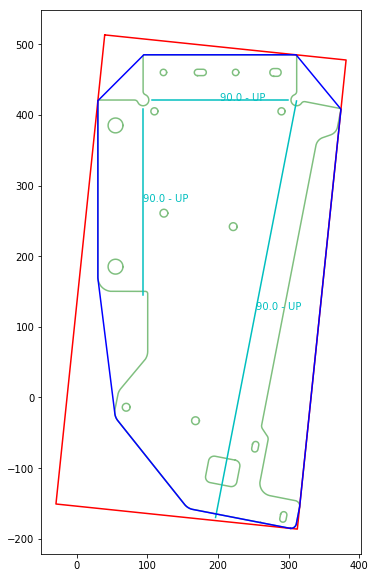

In [123]:
plot_dxf(details)

In [124]:
len(details['closed_patterns'])

16

# Plot a DXF

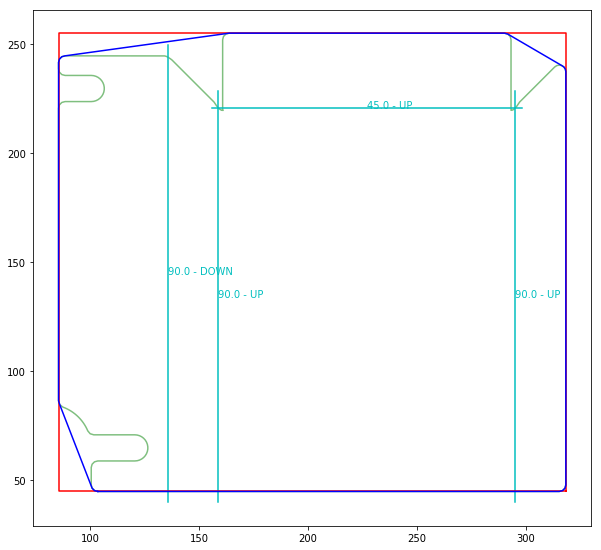

In [110]:
def plot_dxf(dxfdetails):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for closedsection in dxfdetails['closed_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='g', alpha=0.5)
    
    for opensection in dxfdetails['open_patterns']:
        lines = LineString(opensection)
        x, y = lines.xy
        plt.plot(x, y, color='y', alpha=1)
    
    for bendlines in dxfdetails['bend_line']:
        lines = LineString(bendlines)
        x, y = lines.xy
        plt.plot(x, y, color='c', alpha=1)
    
    centeraxis = [((x[0,0]+x[1,0])/2, (x[0,1]+x[1,1])/2) for x in dxfdetails['bend_line']]
    for center, angle, direction in zip(centeraxis, dxfdetails['bend_angle'], dxfdetails['bend_direction'],):
        ax.text(center[0], center[1], '{} - {}'.format(angle, direction), color='c')
        pass
    
    poly = Polygon(dxfdetails['minimum_rectangle_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='r')
    
    poly = Polygon(dxfdetails['convex_hull_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='b')
    
    ax.set_aspect('equal')
    #ax.set_xlim([-220,-160])
    #ax.set_ylim([50,120])
    plt.show()
    
plot_dxf(details)

In [574]:
details.keys()

dict_keys(['closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'num_closed_patterns', 'convex_hull_coords', 'convex_hull_area'])

# Dataset creation

In [126]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample', 'DXF')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]

columns = ['cut_length', 'num_closed_patterns', 'total_area', 'minimum_rectangle_area',
           'convex_hull_area', 'thickness', 'num_open_patterns']

dataset = pd.DataFrame(columns = columns)
dxfparser = DxfParser(min_edge_length=.1)
for dxffile in dxflist:
    name = dxffile.split('/')[-1]
    name = name.split('.')[0]
    print(name)
    details = details = dxfparser.parse(dxffile)
    dataset.loc[name] = [details.get(x, np.nan) for x in dataset.columns]
dataset

a5377710_lr
7
84
closed loop
closed loop
closed loop
closed loop
closed loop
closed loop
ECHELLE 1
 90.00~UP
(253.61808817679997, 124.8074993711)
0.279519353472
 90.00~UP
(202.4330968517, 421.0810665659)
0.279526266749
 90.00~UP
(93.6583579459, 282.179428607)
5.25403179416
b2069320_lr
7
41
closed loop
ECHELLE 1
 90.00~DOWN
(135.3784626433, 144.5901154877)
0.279534985396
 90.00~UP
(158.6456936643, 133.9901154877)
0.279507238198
 90.00~UP
(295.0129246852, 133.9901154877)
0.279479491778
 45.00~UP
(226.8293091747, 220.5819232429)
0.279489897044
c5602250_lr
3
50
closed loop
ECHELLE 1
 90.00~UP
(187.8860121664, 171.5774864555)
0.279503673064
 90.00~UP
(187.8860121664, 128.0123484932)
0.279475930984


,cut_length,num_closed_patterns,total_area,minimum_rectangle_area,convex_hull_area,thickness,num_open_patterns
a5377710_lr,2726.260529,16.0,149327.502374,229537.720481,190139.704744,NaN,0.0
b2069320_lr,1015.039541,1.0,46242.421081,49004.753536,48033.571416,NaN,0.0
c5602250_lr,683.938786,1.0,7242.240650,13589.006460,12425.164736,NaN,0.0


To add in the dataset:
- rectangle area
- rectangle dimension (height and width)
- Main area (no holes)
- convex hull area (no holes)
- bends:
    - Placement relative to outside edges (Min length, number, distance)
    - placement relative to other bends (Distance)
    - Angle, direction
- Number of open loops
- Number of closed loops
- Cut Length
- Thickness
- Material grade